Found 24000 pairs of images and radar data.
Found 6000 pairs of images and radar data.
Found 3000 pairs of images and radar data.


Loading Data: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


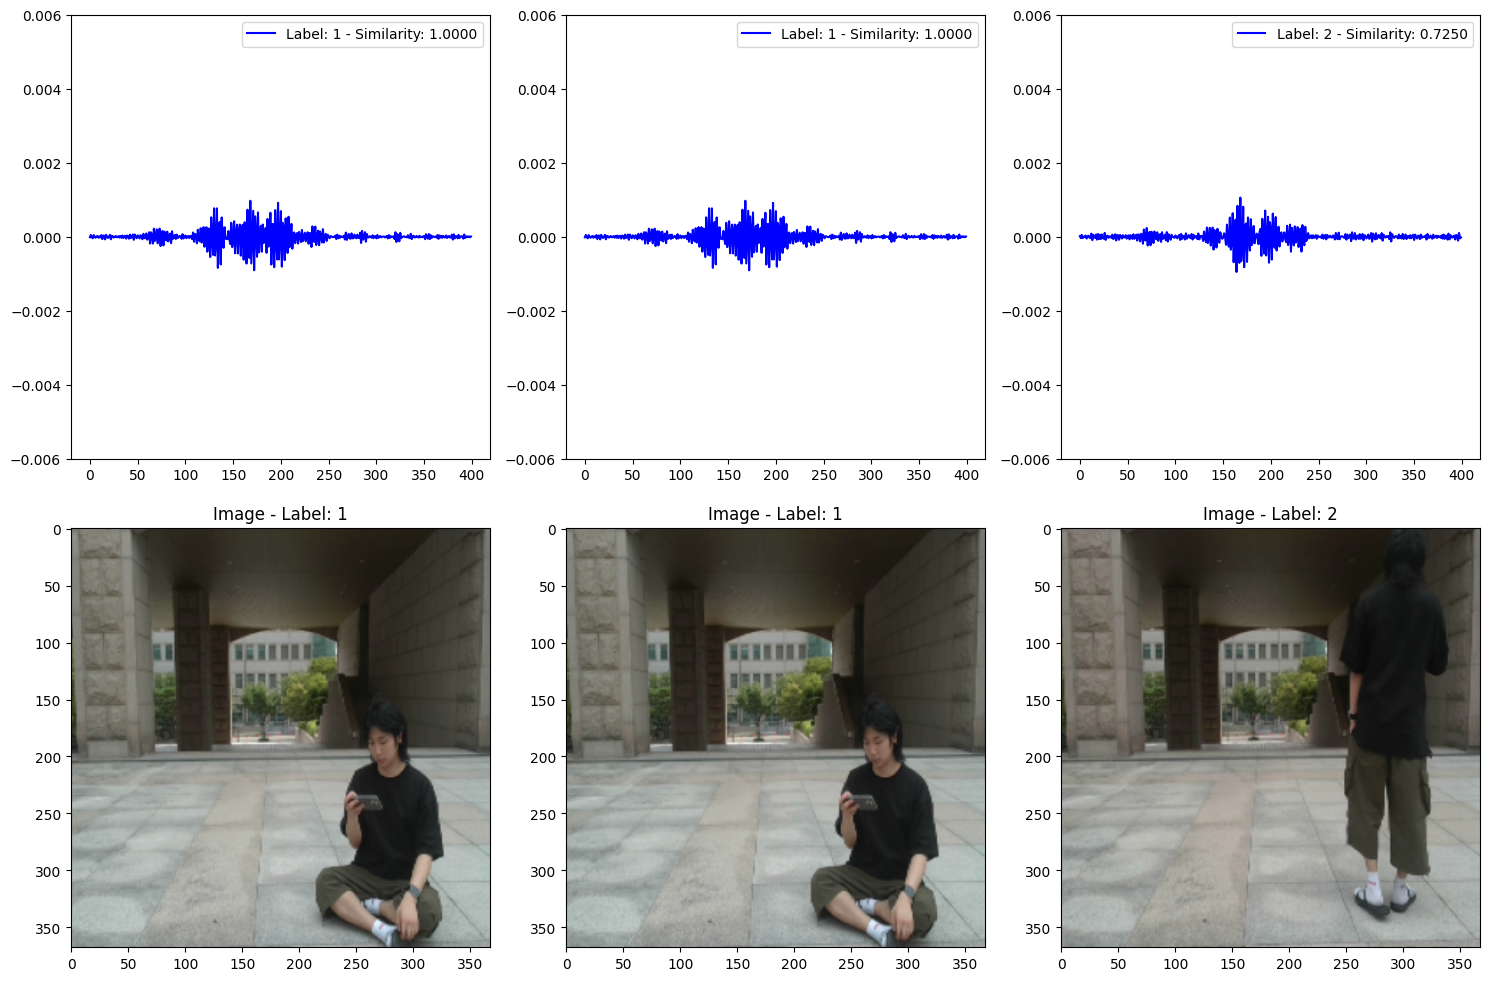

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from dataload import PairedDataset
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tqdm import tqdm
import pdb

# Image data transformation
image_transform = transforms.Compose([
    transforms.Resize((368, 368)),
    transforms.ToTensor(),
])

# Load datasets
radar_range = [200, 600]
radar_normalize = False

# Paths to data
image_data_path_train = '/home/yunkwan/project/radarclip/data_train/image'
radar_data_path_train = '/home/yunkwan/project/radarclip/data_train/radar'
image_data_path_val = '/home/yunkwan/project/radarclip/data_val/image'
radar_data_path_val = '/home/yunkwan/project/radarclip/data_val/radar'
image_data_path_test = '/home/yunkwan/project/radarclip/data_test/image'
radar_data_path_test = '/home/yunkwan/project/radarclip/data_test/radar'

# Dataset and DataLoader setup
paired_dataset_train = PairedDataset(
    image_root_dir=image_data_path_train,
    radar_root_dir=radar_data_path_train,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
train_loader = DataLoader(paired_dataset_train, batch_size=256, shuffle=True)

paired_dataset_val = PairedDataset(
    image_root_dir=image_data_path_val,
    radar_root_dir=radar_data_path_val,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
val_loader = DataLoader(paired_dataset_val, batch_size=256, shuffle=True)

paired_dataset_test = PairedDataset(
    image_root_dir=image_data_path_test,
    radar_root_dir=radar_data_path_test,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
test_loader = DataLoader(paired_dataset_test, batch_size=256, shuffle=True)

# Load data function
def load_data(loader):
    radar_data_list = []
    label_list = []
    image_list = []
    with torch.no_grad():
        for images, radars, images_path, radars_path, labels in tqdm(loader, desc="Loading Data"):
            radar_data_list.append(radars)
            label_list.append(labels)
            image_list.append(images)

    radar_data = torch.cat(radar_data_list).numpy()
    labels = torch.cat(label_list).numpy()
    images = torch.cat(image_list)
    return radar_data, labels, images

# Calculate similarity
def calculate_similarity(radar1, radar2, method='cosine'):
    radar1_flat = radar1.flatten()
    radar2_flat = radar2.flatten()
    
    if method == 'cosine':
        return np.dot(radar1_flat, radar2_flat) / (np.linalg.norm(radar1_flat) * np.linalg.norm(radar2_flat))
    elif method == 'mse':
        return np.mean((radar1_flat - radar2_flat) ** 2)
    elif method == 'dtw':
        radar1_flat = radar1_flat.reshape(1, -1)
        radar2_flat = radar2_flat.reshape(1, -1)
        distance, _ = fastdtw(radar1_flat, radar2_flat, dist=euclidean)
        return -distance

# Visualize results
def visualize_results(images, radars, indices, similarities, labels, method, ylim=0.006):
    fig, axs = plt.subplots(2, len(indices), figsize=(15, 10))
    
    for idx, (i, similarity) in enumerate(zip(indices, similarities)):
        axs[0, idx].plot(radars[i].flatten(), color='blue', label=f"Label: {labels[i]} - Similarity: {similarity:.4f}")
        axs[0, idx].set_ylim(-ylim, ylim)
        axs[0, idx].legend()
        axs[1, idx].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        axs[1, idx].set_title(f"Image - Label: {labels[i]}")
    plt.tight_layout()
    plt.show()

# Load data from the test loader
radar_data, labels, images = load_data(val_loader)

# Show similar pairs
def show_similar_pairs(index_0, method='cosine', ylim=0.006):
    labels_1 = np.where(labels == 1)[0]
    best_similarity_0_1 = -1 if method == 'cosine' else np.inf
    best_index_1 = None
    for j in labels_1:
        similarity = calculate_similarity(radar_data[index_0], radar_data[j], method)
        if (method == 'cosine' and similarity > best_similarity_0_1) or (method in ['mse', 'dtw'] and similarity < best_similarity_0_1):
            best_similarity_0_1 = similarity
            best_index_1 = j

    labels_2 = np.where(labels == 2)[0]
    best_similarity_0_2 = -1 if method == 'cosine' else np.inf
    best_index_2 = None
    for j in labels_2:
        similarity = calculate_similarity(radar_data[index_0], radar_data[j], method)
        if (method == 'cosine' and similarity > best_similarity_0_2) or (method in ['mse', 'dtw'] and similarity < best_similarity_0_2):
            best_similarity_0_2 = similarity
            best_index_2 = j

    indices = [index_0, best_index_1, best_index_2]
    similarities = [1.0 if method == 'cosine' else 0.0, best_similarity_0_1, best_similarity_0_2]
    visualize_results(images, radar_data, indices, similarities, labels, method, ylim)

# Example usage
show_similar_pairs(index_0=5, method='cosine')


Found 24000 pairs of images and radar data.
Found 6000 pairs of images and radar data.
Found 3000 pairs of images and radar data.


Loading Data:   0%|          | 0/24 [00:00<?, ?it/s]

Finding Most Similar to Label 2: 100%|██████████| 2000/2000 [00:00<00:00, 150129.00it/s]


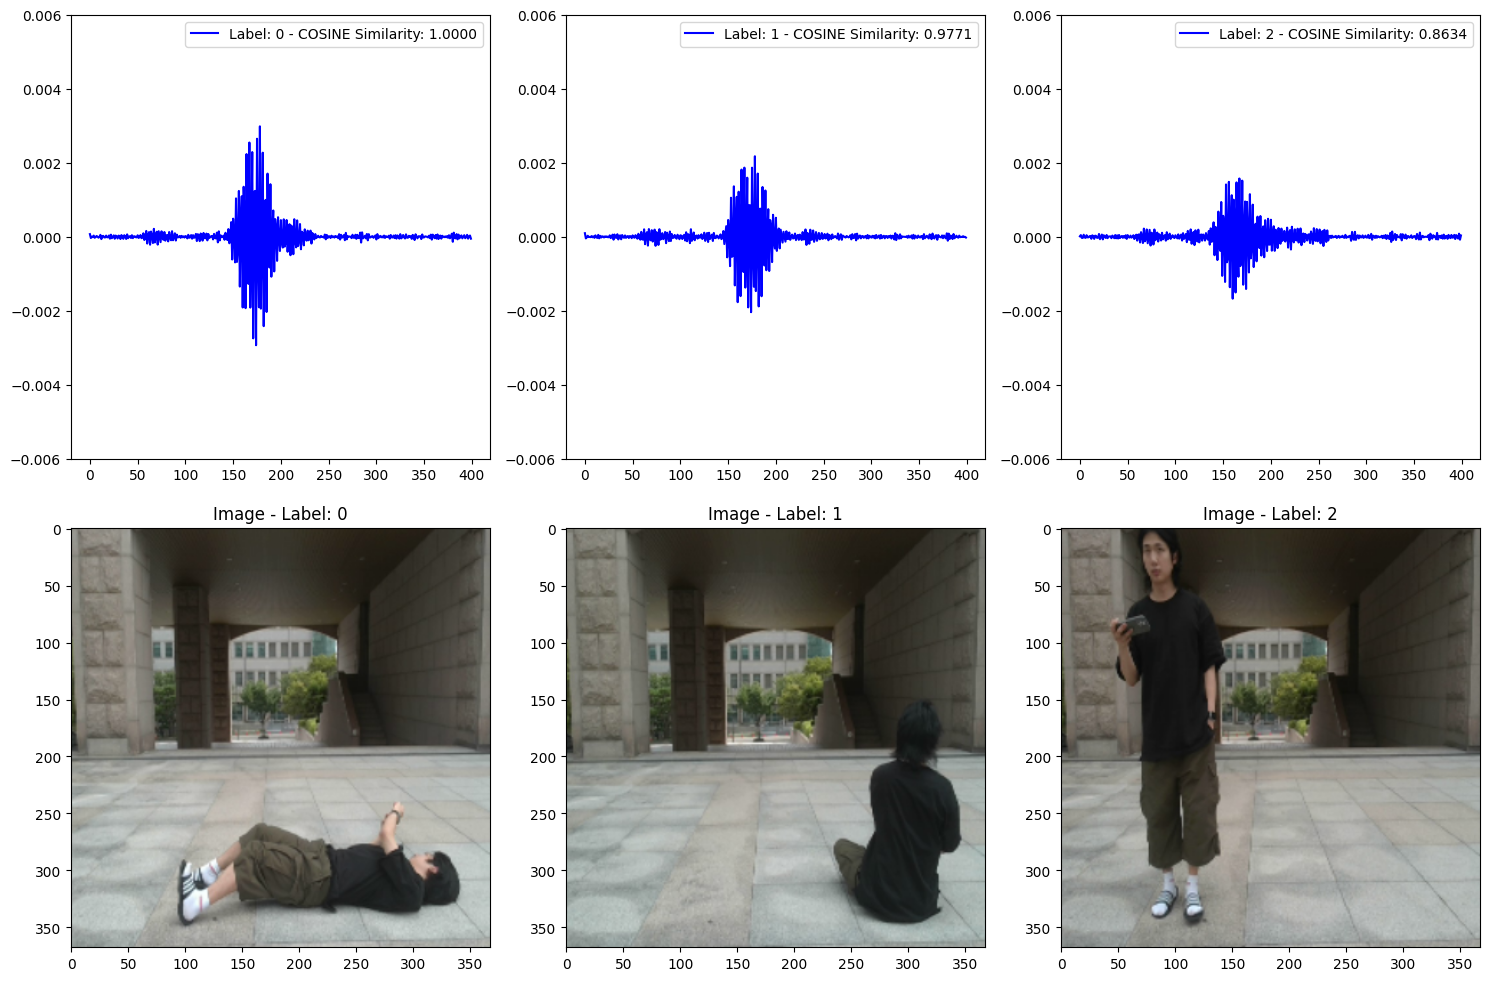

<Figure size 640x480 with 0 Axes>

In [16]:
# 기존 백업코드

import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from dataload import PairedDataset
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tqdm import tqdm  # 추가
import pdb
# Image data transformation
image_transform = transforms.Compose([
    transforms.Resize((368, 368)),
    transforms.ToTensor(),

])

# Load datasets
radar_range = [200, 600]
radar_normalize = False

# Paths to data
image_data_path_train = '/home/yunkwan/project/radarclip/data_train/image'
radar_data_path_train = '/home/yunkwan/project/radarclip/data_train/radar'
image_data_path_val = '/home/yunkwan/project/radarclip/data_val/image'
radar_data_path_val = '/home/yunkwan/project/radarclip/data_val/radar'
image_data_path_test = '/home/yunkwan/project/radarclip/data_test/image'
radar_data_path_test = '/home/yunkwan/project/radarclip/data_test/radar'

# Train dataset
paired_dataset_train = PairedDataset(
    image_root_dir=image_data_path_train,
    radar_root_dir=radar_data_path_train,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
train_loader = DataLoader(paired_dataset_train, batch_size=256, shuffle=True)

# Validation dataset
paired_dataset_val = PairedDataset(
    image_root_dir=image_data_path_val,
    radar_root_dir=radar_data_path_val,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
val_loader = DataLoader(paired_dataset_val, batch_size=256, shuffle=True)

# Test dataset
paired_dataset_test = PairedDataset(
    image_root_dir=image_data_path_test,
    radar_root_dir=radar_data_path_test,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
test_loader = DataLoader(paired_dataset_test, batch_size=256, shuffle=True)

# Function to load data from the loader
def load_data(loader):
    radar_data_list = []
    label_list = []
    image_list = []
    with torch.no_grad():
        for images, radars, images_path, radars_path, labels in tqdm(loader, desc="Loading Data"):
            radar_data_list.append(radars)
            label_list.append(labels)
            image_list.append(images)

    radar_data = torch.cat(radar_data_list).numpy()
    labels = torch.cat(label_list).numpy()
    images = torch.cat(image_list)
    return radar_data, labels, images

# Function to calculate similarity
def calculate_similarity(radar1, radar2, method='cosine'):
    radar1_flat = radar1.flatten()
    radar2_flat = radar2.flatten()
    
    if method == 'cosine':
        similarity = np.dot(radar1_flat, radar2_flat) / (
            np.linalg.norm(radar1_flat) * np.linalg.norm(radar2_flat))
    elif method == 'mse':
        similarity = np.mean((radar1_flat - radar2_flat) ** 2)  # MSE for similarity
    elif method == 'dtw':
        radar1_flat = radar1_flat.reshape(1, -1)
        radar2_flat = radar2_flat.reshape(1, -1)
        distance, _ = fastdtw(radar1_flat, radar2_flat, dist=euclidean)
        similarity = distance  # Use negative distance for similarity
    return similarity

# Function to find the most similar pair of 0 and 1 labels
def find_most_similar_0_and_1(radar_data, labels, method='cosine'):
    similarities = []
    labels_0 = np.where(labels == 0)[0]
    labels_1 = np.where(labels == 1)[0]
    
    for i in tqdm(labels_0, desc="Finding Most Similar to Label 0"):
        if labels[i] == 0:
            for j in labels_1:            
                similarity = calculate_similarity(radar_data[i], radar_data[j], method)
                similarities.append((similarity, i, j))
    similarities.sort(key=lambda x: x[0], reverse=(method == 'cosine'))

    return similarities

# Function to find the most similar 2 label for a given index
def find_most_similar_to_2(radar_data, labels, index, method='cosine'):
    # labels_0 = np.where(labels == 0)[0]
    labels_2 = np.where(labels == 2)[0]
    
    best_similarity = -1 if method == 'cosine' else np.inf
    best_index = None
    for i in tqdm(labels_2, desc="Finding Most Similar to Label 2"):
        similarity = calculate_similarity(radar_data[index], radar_data[i], method)
        if (method == 'cosine' and similarity > best_similarity) or (method in ['mse', 'dtw'] and similarity < best_similarity):
            best_similarity = similarity
            best_index = i
            
    return best_index, best_similarity

# Function to visualize the results
def visualize_results(images, radars, indices, similarities, labels, method, ylim=0.006):
    fig, axs = plt.subplots(2, len(indices), figsize=(15, 10))
    
    for idx, (i, similarity) in enumerate(zip(indices, similarities)):
        if method == 'cosine':
            similarity_label = f"{similarity:.4f}"
        elif method in ['mse', 'dtw']:
            similarity_label = f"{similarity:.4e}"
        
        # First row: Radar data visualization
        axs[0, idx].plot(radars[i].flatten(), color='blue', label=f"Label: {labels[i]} - {method.upper()} Similarity: {similarity_label}")
        axs[0, idx].set_ylim(-ylim, ylim)
        axs[0, idx].legend()
        axs[0, idx].axis('on')
        
        # Second row: Image visualization
        axs[1, idx].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        axs[1, idx].set_title(f"Image - Label: {labels[i]}")
        axs[1, idx].axis('on')
        
    plt.tight_layout()
    plt.show()
    plt.savefig(f'/home/yunkwan/project/radarclip/similar_plot_{method}')

# Load data from the test loader
radar_data, labels, images = load_data(val_loader)

def show_similar_pairs(k=1, method='cosine', ylim=0.006):
    # Find the most similar 0 and 1 label pairs
    top_similarities = find_most_similar_0_and_1(radar_data, labels, method)
    if len(top_similarities) < k:
        print(f"Only found {len(top_similarities)} pairs, cannot show the {k}th pair")
        return

    # Select the k-th most similar pair
    similarity_0_1, index_0, index_1 = top_similarities[k-1]

    # Find the most similar 2 label for the selected 0 label index
    most_similar_to_2, similarity_0_2 = find_most_similar_to_2(radar_data, labels, index_0, method)

    # Indices and similarities to visualize
    indices = [index_0, index_1, most_similar_to_2]
    similarities = [1.0 if method == 'cosine' else 0.0, similarity_0_1, similarity_0_2]

    # Visualize the results
    visualize_results(images, radar_data, indices, similarities, labels, method, ylim)

# Example: Show the first most similar pairs using cosine similarity
show_similar_pairs(k=1, method='cosine')

# Example: Show the first most similar pairs using DTW similarity
# show_similar_pairs(k=1, method='dtw', ylim=0.006)

# Example: Show the second most similar pairs using MSE
# show_similar_pairs(k=1, method='mse', ylim=0.006)


Found 24000 pairs of images and radar data.
Found 6000 pairs of images and radar data.
Found 3000 pairs of images and radar data.


Finding Most Similar to Label 1: 100%|██████████| 2000/2000 [01:20<00:00, 24.89it/s]


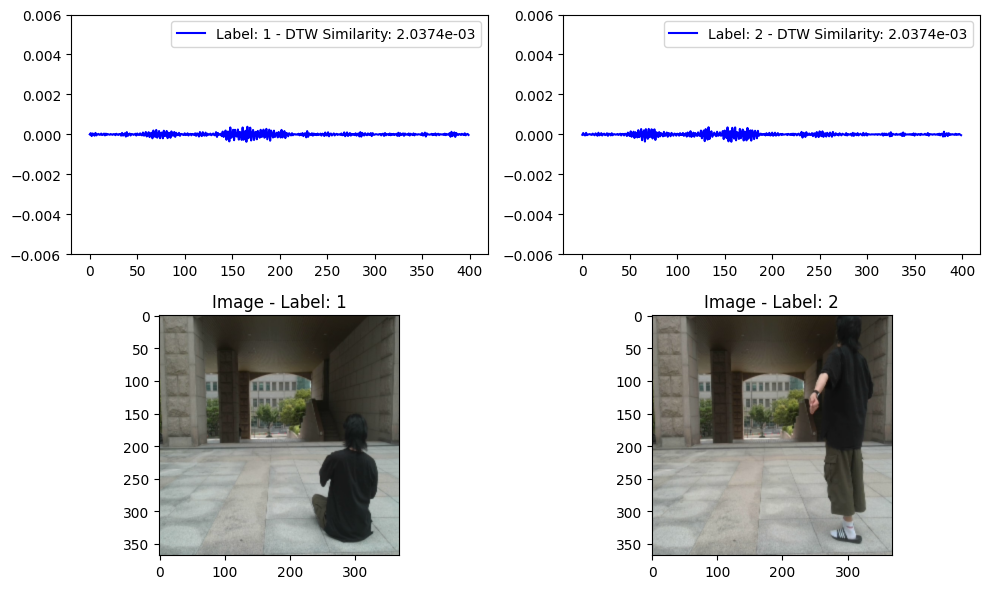

<Figure size 640x480 with 0 Axes>

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from dataload import PairedDataset
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tqdm import tqdm  # 추가
import pdb

# Image data transformation
image_transform = transforms.Compose([
    transforms.Resize((368, 368)),
    transforms.ToTensor(),
])

# Load datasets
radar_range = [200, 600]
radar_normalize = False

# Paths to data
image_data_path_train = '/home/yunkwan/project/radarclip/data_train/image'
radar_data_path_train = '/home/yunkwan/project/radarclip/data_train/radar'
image_data_path_val = '/home/yunkwan/project/radarclip/data_val/image'
radar_data_path_val = '/home/yunkwan/project/radarclip/data_val/radar'
image_data_path_test = '/home/yunkwan/project/radarclip/data_test/image'
radar_data_path_test = '/home/yunkwan/project/radarclip/data_test/radar'

# Train dataset
paired_dataset_train = PairedDataset(
    image_root_dir=image_data_path_train,
    radar_root_dir=radar_data_path_train,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
train_loader = DataLoader(paired_dataset_train, batch_size=256, shuffle=True)

# Validation dataset
paired_dataset_val = PairedDataset(
    image_root_dir=image_data_path_val,
    radar_root_dir=radar_data_path_val,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
val_loader = DataLoader(paired_dataset_val, batch_size=256, shuffle=True)

# Test dataset
paired_dataset_test = PairedDataset(
    image_root_dir=image_data_path_test,
    radar_root_dir=radar_data_path_test,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
test_loader = DataLoader(paired_dataset_test, batch_size=256, shuffle=True)

# Function to load data from the loader
def load_data(loader):
    radar_data_list = []
    label_list = []
    image_list = []
    with torch.no_grad():
        for images, radars, images_path, radars_path, labels in tqdm(loader, desc="Loading Data"):
            radar_data_list.append(radars)
            label_list.append(labels)
            image_list.append(images)

    radar_data = torch.cat(radar_data_list).numpy()
    labels = torch.cat(label_list).numpy()
    images = torch.cat(image_list)
    return radar_data, labels, images


# Function to calculate similarity
def calculate_similarity(radar1, radar2, method='cosine'):
    radar1_flat = radar1.flatten()
    radar2_flat = radar2.flatten()
    
    if method == 'cosine':
        similarity = np.dot(radar1_flat, radar2_flat) / (
            np.linalg.norm(radar1_flat) * np.linalg.norm(radar2_flat))
    elif method == 'mse':
        similarity = np.mean((radar1_flat - radar2_flat) ** 2)  # MSE for similarity
    elif method == 'dtw':
        radar1_flat = radar1_flat.reshape(1, -1)
        radar2_flat = radar2_flat.reshape(1, -1)
        distance, _ = fastdtw(radar1_flat, radar2_flat, dist=euclidean)
        similarity = distance  # Use negative distance for similarity
    return similarity

# Function to find the most similar pair for two specific labels
def find_most_similar_labels(radar_data, labels, label1, label2, method='cosine'):
    similarities = []
    indices_label1 = np.where(labels == label1)[0]
    indices_label2 = np.where(labels == label2)[0]
    
    for i in tqdm(indices_label1, desc=f"Finding Most Similar to Label {label1}"):
        for j in indices_label2:
            similarity = calculate_similarity(radar_data[i], radar_data[j], method)
            similarities.append((similarity, i, j))
    if method == 'cosine':
        similarities.sort(key=lambda x: x[0], reverse=True)
    else:
        similarities.sort(key=lambda x: x[0])

    return similarities

# Function to visualize the results
def visualize_results(images, radars, indices, similarities, labels, method, ylim=0.006):
    fig, axs = plt.subplots(2, len(indices), figsize=(10, 6))
    
    for idx, (i, similarity) in enumerate(zip(indices, similarities)):
        if method == 'cosine':
            similarity_label = f"{similarity:.4f}"
        elif method in ['mse', 'dtw']:
            similarity_label = f"{similarity:.4e}"
        
        # First row: Radar data visualization
        axs[0, idx].plot(radars[i].flatten(), color='blue', label=f"Label: {labels[i]} - {method.upper()} Similarity: {similarity_label}")
        axs[0, idx].set_ylim(-ylim, ylim)
        axs[0, idx].legend()
        axs[0, idx].axis('on')
        
        # Second row: Image visualization
        axs[1, idx].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        axs[1, idx].set_title(f"Image - Label: {labels[i]}")
        axs[1, idx].axis('on')
        
    plt.tight_layout()
    plt.show()
    plt.savefig(f'/home/yunkwan/project/radarclip/similar_plot_{method}')

# Load data from the test loader
radar_data, labels, images = load_data(val_loader)

def show_similar_pairs(label1, label2, k=1, method='cosine', ylim=0.006):
    # Find the most similar pairs for the specified labels
    top_similarities = find_most_similar_labels(radar_data, labels, label1, label2, method)
    if len(top_similarities) < k:
        print(f"Only found {len(top_similarities)} pairs, cannot show the {k}th pair")
        return

    # Select the k-th most similar pair
    similarity, index1, index2 = top_similarities[k-1]

    # Indices and similarities to visualize
    indices = [index1, index2]
    similarities = [similarity, similarity]

    # Visualize the results
    visualize_results(images, radar_data, indices, similarities, labels, method, ylim)

# Example: Show the first most similar pairs using cosine similarity for labels 0 and 1
# show_similar_pairs(label1=1, label2=2, k=1, method='cosine')

# Example: Show the first most similar pairs using DTW similarity for labels 0 and 2
show_similar_pairs(label1=1, label2=2, k=1, method='dtw', ylim=0.006)

# Example: Show the first most similar pairs using MSE for labels 1 and 2
# show_similar_pairs(label1=1, label2=2, k=1, method='mse', ylim=0.006)


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from dataload import PairedDataset
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tqdm import tqdm

# Image data transformation
image_transform = transforms.Compose([
    transforms.Resize((368, 368)),
    transforms.ToTensor(),
])

# Load datasets
radar_range = [200, 600]
radar_normalize = False

# Paths to data
image_data_path_train = '/home/yunkwan/project/radarclip/data_train/image'
radar_data_path_train = '/home/yunkwan/project/radarclip/data_train/radar'
image_data_path_val = '/home/yunkwan/project/radarclip/data_val/image'
radar_data_path_val = '/home/yunkwan/project/radarclip/data_val/radar'
image_data_path_test = '/home/yunkwan/project/radarclip/data_test/image'
radar_data_path_test = '/home/yunkwan/project/radarclip/data_test/radar'

# Train dataset
paired_dataset_train = PairedDataset(
    image_root_dir=image_data_path_train,
    radar_root_dir=radar_data_path_train,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
train_loader = DataLoader(paired_dataset_train, batch_size=256, shuffle=True)

# Validation dataset
paired_dataset_val = PairedDataset(
    image_root_dir=image_data_path_val,
    radar_root_dir=radar_data_path_val,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
val_loader = DataLoader(paired_dataset_val, batch_size=256, shuffle=True)

# Test dataset
paired_dataset_test = PairedDataset(
    image_root_dir=image_data_path_test,
    radar_root_dir=radar_data_path_test,
    radar_range=radar_range,
    transform=image_transform,
    radar_normalize=radar_normalize
)
test_loader = DataLoader(paired_dataset_test, batch_size=256, shuffle=True)

# Function to load data from the loader
def load_data(loader):
    radar_path_list = []
    label_list = []
    image_path_list = []
    with torch.no_grad():
        for images, radars, images_path, radars_path, labels in tqdm(loader, desc="Loading Data"):
            radar_path_list.extend(radars_path)
            label_list.append(labels)
            image_path_list.extend(images_path)

    labels = torch.cat(label_list).numpy()
    return radar_path_list, labels, image_path_list

# Function to calculate similarity
def calculate_similarity(radar1, radar2, method='cosine'):
    radar1 = np.load(radar1)
    radar2 = np.load(radar2)
    radar1_flat = radar1.flatten()
    radar2_flat = radar2.flatten()
    
    if method == 'cosine':
        similarity = np.dot(radar1_flat, radar2_flat) / (
            np.linalg.norm(radar1_flat) * np.linalg.norm(radar2_flat))
    elif method == 'mse':
        similarity = np.mean((radar1_flat - radar2_flat) ** 2)  # MSE for similarity
    elif method == 'dtw':
        radar1_flat = radar1_flat.reshape(1, -1)
        radar2_flat = radar2_flat.reshape(1, -1)
        distance, _ = fastdtw(radar1_flat, radar2_flat, dist=euclidean)
        similarity = -distance  # Use negative distance for similarity
    return similarity

# Function to find the most similar pair of 0 and 1 labels
def find_most_similar_0_and_1(radar_data, labels, method='cosine'):
    similarities = []
    labels_0 = np.where(labels == 0)[0]
    labels_1 = np.where(labels == 1)[0]
    
    for i in tqdm(labels_0, desc="Finding Most Similar to Label 0"):
        for j in labels_1:            
            similarity = calculate_similarity(radar_data[i], radar_data[j], method)
            similarities.append((similarity, i, j))
    similarities.sort(key=lambda x: x[0], reverse=(method == 'cosine'))

    return similarities

# Function to find the most similar 2 label for a given index
def find_most_similar_to_2(radar_data, labels, index, method='cosine'):
    labels_2 = np.where(labels == 2)[0]
    
    best_similarity = -1 if method == 'cosine' else np.inf
    best_index = None
    for i in tqdm(labels_2, desc="Finding Most Similar to Label 2"):
        similarity = calculate_similarity(radar_data[index], radar_data[i], method)
        if (method == 'cosine' and similarity > best_similarity) or (method in ['mse', 'dtw'] and similarity < best_similarity):
            best_similarity = similarity
            best_index = i
            
    return best_index, best_similarity

# Function to visualize the results
def visualize_results(image_paths, radar_paths, indices, similarities, labels, method, ylim=0.006):
    fig, axs = plt.subplots(2, len(indices), figsize=(15, 10))
    
    for idx, (i, similarity) in enumerate(zip(indices, similarities)):
        if method == 'cosine':
            similarity_label = f"{similarity:.4f}"
        elif method in ['mse', 'dtw']:
            similarity_label = f"{similarity:.4e}"
        
        # First row: Radar data visualization
        radar_data = np.load(radar_paths[i])
        axs[0, idx].plot(radar_data.flatten(), color='blue', label=f"Label: {labels[i]} - {method.upper()} Similarity: {similarity_label}")
        axs[0, idx].set_ylim(-ylim, ylim)
        axs[0, idx].legend()
        axs[0, idx].axis('on')
        
        # Second row: Image visualization
        image = plt.imread(image_paths[i])
        axs[1, idx].imshow(image)
        axs[1, idx].set_title(f"Image - Label: {labels[i]}")
        axs[1, idx].axis('on')
        
    plt.tight_layout()
    plt.show()
    plt.savefig(f'/home/yunkwan/project/radarclip/similar_plot_{method}')

# Load data from the train loader
radar_paths, labels, image_paths = load_data(val_loader)

def show_similar_pairs(k=1, method='cosine', ylim=0.006):
    # Find the most similar 0 and 1 label pairs
    top_similarities = find_most_similar_0_and_1(radar_paths, labels, method)
    if len(top_similarities) < k:
        print(f"Only found {len(top_similarities)} pairs, cannot show the {k}th pair")
        return

    # Select the k-th most similar pair
    similarity_0_1, index_0, index_1 = top_similarities[k-1]

    # Find the most similar 2 label for the selected 0 label index
    most_similar_to_2, similarity_0_2 = find_most_similar_to_2(radar_paths, labels, index_0, method)

    # Indices and similarities to visualize
    indices = [index_0, index_1, most_similar_to_2]
    similarities = [1.0 if method == 'cosine' else 0.0, similarity_0_1, similarity_0_2]

    # Visualize the results
    visualize_results(image_paths, radar_paths, indices, similarities, labels, method, ylim)

# Example: Show the first most similar pairs using cosine similarity
show_similar_pairs(k=1, method='cosine')

# Example: Show the first most similar pairs using DTW similarity
# show_similar_pairs(k=1, method='dtw', ylim=0.006)

# Example: Show the second most similar pairs using MSE
# show_similar_pairs(k=2, method='mse', ylim=0.006)


Found 24000 pairs of images and radar data.
Found 6000 pairs of images and radar data.
Found 3000 pairs of images and radar data.


Finding Most Similar to Label 0:   1%|          | 22/2000 [00:07<10:36,  3.11it/s]


KeyboardInterrupt: 